In [1]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

In [2]:
import os

import torch
from common import utils
from ultralytics import YOLO

# Useful constants
CURRENT_DIR = os.getcwd()
IMAGES_DIR = os.path.join(CURRENT_DIR, "images")
VIDEOS_DIR = os.path.join(CURRENT_DIR, "videos")
CHORD_CLASSIFIER_MODEL_DIR = os.path.join(CURRENT_DIR, "chord-classifier-model")
FRETBOARD_RECOGNIZER_MODEL_DIR = os.path.join(CURRENT_DIR, "fretboard-recognizer-model")

chord_clf_model_path = utils.find_files(CHORD_CLASSIFIER_MODEL_DIR, [".safetensors", ".pt"])
chord_clf_config_path = utils.find_files(CHORD_CLASSIFIER_MODEL_DIR, [".json"])
fretboard_rec_model_path = utils.find_files(FRETBOARD_RECOGNIZER_MODEL_DIR, [".safetensors", ".pt"])
fretboard_rec_config_path = utils.find_files(FRETBOARD_RECOGNIZER_MODEL_DIR, [".json"])

utils.ensure_files_exist(
    chord_clf_model_path,
    fretboard_rec_model_path,
    chord_clf_config_path,
    fretboard_rec_config_path,
    names=[
        "Chord Classifier model",
        "Fretboard Recognizer model",
        "Chord Classifier config",
        "Fretboard Recognizer config",
    ],
)

Chord Classifier model found at /home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/chord-classifier-model/model.safetensors
Fretboard Recognizer model found at /home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/fretboard-recognizer-model/yolov9c_trained_with_head.pt
Chord Classifier config found at /home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/chord-classifier-model/config.json
Fretboard Recognizer config not found


In [3]:
# Load Chord Classifier model
chord_clf_model = utils.load_model(chord_clf_model_path, config_path=chord_clf_config_path)

# Load Fretboard Recognizer model
fretboard_rec_model = utils.load_model(fretboard_rec_model_path, config_path=fretboard_rec_config_path, custom_class=YOLO)

print("Models loaded successfully.")

Models loaded successfully.


In [4]:
IMAGES = utils.find_files(IMAGES_DIR, [".jpg", ".jpeg", ".png"], find_all=True)
print(f"Found {len(IMAGES)} images for testing:")
for img in IMAGES:
    print(f"\t{img}")

Found 3 images for testing:
	/home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/images/test-fretboard-2.jpg
	/home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/images/test-fretboard-3.jpg
	/home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/images/test-fretboard.jpg


In [5]:
test_image = utils.load_image_to_numpy(IMAGES[2])


0: 384x640 1 person, 1 fretboard, 93.9ms
Speed: 1.8ms preprocess, 93.9ms inference, 88.6ms postprocess per image at shape (1, 3, 384, 640)


/home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/common/utils.py:304: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


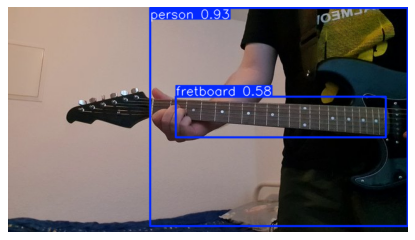

In [6]:
utils.show_model_output([fretboard_rec_model.predict(test_image)[0].plot()])


0: 384x640 1 person, 1 fretboard, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


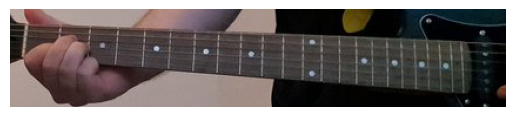

In [7]:
extracted_fretboard = utils.extract_box_object(
    fretboard_rec_model, test_image, class_name="fretboard", conf=0.25, expand_percent=15
)
if extracted_fretboard is not None:
    import matplotlib.pyplot as plt

    plt.imshow(extracted_fretboard)
    plt.axis("off")
    plt.savefig("extracted_fretboard.png")
else:
    print("Failed to extract the object.")

In [8]:
predicted_chord = utils.predict_chord(chord_clf_model, extracted_fretboard)
print(f"Predicted chord: {predicted_chord}")

Predicted chord: D


In [19]:
import cv2
import torch
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from common.transforms import infer_transforms, resize
from common.annotations import inference_annotations, annotate_fps, convert_detections


def process_video_with_chord_prediction(
    video_path,
    fretboard_model,
    chord_model,
    prediction_interval=30,
    detection_threshold=0.3,
    imgsz=None,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
):
    """
    Process a video, detecting fretboards, predicting chords, and displaying results.

    Args:
    video_path (str): Path to the video file.
    fretboard_model: YOLO model for fretboard detection.
    chord_model: Model for chord classification.
    prediction_interval (int): Number of frames to skip between chord predictions.
    detection_threshold (float): Threshold for object detection.
    imgsz (int): Resize image to this size, if None use original size.
    device (torch.device): Computation device.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    if imgsz is None:
        RESIZE_TO = frame_width
    else:
        RESIZE_TO = imgsz

    frame_count = 0
    total_fps = 0
    chord_predictions = []

    # Assume CLASSES is defined somewhere in your code
    CLASSES = ["fretboard"]  # Add other classes if needed
    COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

    plt.figure(figsize=(12, 6))
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Resize and prepare frame
        frame = resize(frame, RESIZE_TO)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = infer_transforms(image, RESIZE_TO)
        image = torch.unsqueeze(image, 0)

        # Get the start time
        start_time = time.time()

        # Perform object detection
        with torch.no_grad():
            outputs = fretboard_model(image.to(device))

        # Calculate FPS
        fps = 1 / (time.time() - start_time)
        total_fps += fps

        # Process detections
        outputs = [t.to("cpu") for t in outputs]
        print(outputs[0])
        if len(outputs[0]["boxes"]) != 0:
            draw_boxes, pred_classes, scores = convert_detections(
                outputs, detection_threshold, CLASSES, {"classes": None}
            )
            frame = inference_annotations(
                draw_boxes,
                pred_classes,
                scores,
                CLASSES,
                COLORS,
                frame,
                frame,
                {"no_labels": False},
            )

            # Extract fretboard and predict chord every 'prediction_interval' frames
            if frame_count % prediction_interval == 0:
                for box in draw_boxes:
                    if pred_classes[draw_boxes.index(box)] == "fretboard":
                        x1, y1, x2, y2 = map(int, box)
                        fretboard_image = frame[y1:y2, x1:x2]
                        fretboard_pil = Image.fromarray(
                            cv2.cvtColor(fretboard_image, cv2.COLOR_BGR2RGB)
                        )
                        predicted_chord = utils.predict_chord(chord_model, fretboard_pil)
                        chord_predictions.append(f"Frame {frame_count}: {predicted_chord}")
                        break  # Assume only one fretboard per frame

        frame = annotate_fps(frame, fps)

        # Display the annotated frame
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title("Video Feed")
        plt.axis("off")

        # Display chord predictions
        plt.subplot(1, 2, 2)
        plt.text(0.1, 0.9, "\n".join(chord_predictions[-10:]), fontsize=10, va="top")
        plt.axis("off")
        plt.title("Chord Predictions")

        clear_output(wait=True)
        display(plt.gcf())
        plt.clf()

        time.sleep(0.01)  # Add a small delay to control display speed

    cap.release()
    plt.close()

    # Calculate and print the average FPS
    avg_fps = total_fps / frame_count
    print(f"Average FPS: {avg_fps:.3f}")


# Usage
test_video_path = utils.find_files(VIDEOS_DIR, [".mp4"])
process_video_with_chord_prediction(
    test_video_path, fretboard_rec_model, chord_clf_model, imgsz=640, prediction_interval=30
)


0: 640x640 (no detections), 19.1ms
Speed: 0.0ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'oran

IndexError: too many indices for tensor of dimension 2

<Figure size 1200x600 with 0 Axes>